In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B,TNC
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
import numpy as np
import matplotlib.pyplot as plt
import time, copy, warnings

import torch
import torchvision

from torchvision import datasets, transforms

from sklearn import linear_model, svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from qiskit_algorithms.utils import algorithm_globals
np.random.seed(42)
algorithm_globals.random_seed = 12345


In [2]:
# # Use ad hoc data set for training and test data
# from qiskit_machine_learning.datasets import ad_hoc_data
# size = 2  # dimension of each data point
# training_size = 20
# test_size = 10

# # training features, training labels, test features, test labels as np.ndarray,
# # one hot encoding for labels
# X_train, y_train, X_test, y_test = ad_hoc_data(
#     training_size=training_size, test_size=test_size, n=size, gap=0.3
# )

In [3]:
# Assuming 'model' is your fully connected model
def print_model_parameters(model):
    """
    Print the parameters (weights and biases) of the fully connected model.

    Args:
        model (FCL): The fully connected model.
    """
    # Access the linear layer of the model
    linear_layer = model.fc
    
    # Print weights and biases
    print("Weights:")
    print(linear_layer.weight.data)
    print("Biases:")
    print(linear_layer.bias.data)

# Assuming 'model' is your fully connected model
# You need to instantiate the model before printing its parameters
# model = FCL(2**num_qubits, 2)  # You need to define input_size and output_size here
# # Train the model...
# # After training, call the print_model_parameters function
# print_model_parameters(model)


In [4]:
def cross_entropy(y_pred, y_true):
    # Convert y_pred and y_true to PyTorch tensors
    y_pred_tensor = torch.tensor(y_pred, dtype=torch.float32)
    y_true_tensor = torch.tensor(y_true, dtype=torch.float32)

    # Ensure y_pred_tensor has the shape of y_true_tensor
    if y_pred_tensor.shape != y_true_tensor.shape:
        raise ValueError("Shapes of y_pred and y_true must match.")
    # Compute softmax values for predicted probabilities
    # y_pred_softmax = torch.softmax(y_pred_tensor, dim=-1)
    y_true_softmax = torch.softmax(y_true_tensor, dim=-1)

    # Compute cross-entropy loss
    loss = -torch.sum(y_true_softmax * torch.log(y_pred_tensor + 1e-10))
    # print(loss)
    return loss.item()

## Loading Data

In [5]:
# Load MNIST dataset
def load_dataset(size,train=True):
    root = '~/Documents/image_datasets/MNIST'
    dataset = datasets.MNIST(root=root, train=train, download=True,
                             transform=transforms.Compose([
                                 transforms.Resize((size, size)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=(0.5,), std=(0.5,))
                             ]))
    return dataset


size = 4
trainset = load_dataset(train=True,size=size)
testset = load_dataset(train=False,size=size)



## Selecting Specific Digit

In [6]:
# Generate subset from dataset
def generate_subset(dataset, *classes):
    class_indices = torch.cat([torch.where(dataset.targets == c)[0] for c in classes])
    subset = torch.utils.data.Subset(dataset, class_indices)
    X = np.array([image.flatten().numpy() for image, _ in subset])
    y = np.array([label for _, label in subset])
    return X, y




# 
classes = [0, 1]
X_train, y_train = generate_subset(trainset, *classes)
X_test, y_test = generate_subset(testset, *classes)

# # Randomly sample a subset of data (optional)
# # random_indices_test = np.random.choice(range(len(X_test)), 100, replace=False)
# # X_test, y_test = X_test[random_indices_test], y_test[random_indices_test]

# # random_indices_train = np.random.choice(range(len(X_train)), 1000, replace=False)
# # X_train, y_train = X_train[random_indices_train], y_train[random_indices_train]

In [7]:
def one_hot_encode(values):
    max_value = max(values)
    num_classes = max_value + 1
    one_hot_vectors = []
    for value in values:
        one_hot_vector = [0] * num_classes
        one_hot_vector[value] = 1
        one_hot_vectors.append(one_hot_vector)
    return one_hot_vectors

# Example usage:
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)



In [8]:
# size of the test and train set
print(f'Size of Training set is  {X_train.shape} \n and Testing set is {X_test.shape}')

Size of Training set is  (12665, 16) 
 and Testing set is (2115, 16)


In [9]:
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
import numpy as np

def create_feature_map(size, encoding):
    """
    Creates a feature map circuit based on the specified encoding type.

    Parameters:
        size (int): The size of the features.
        encoding (str): The encoding type. Choose from 'Pauli', 'Z', 'ZZ', or 'RawFeatureVector'.

    Returns:
        qiskit.QuantumCircuit: The feature map quantum circuit.
    """

    num_features = size ** 2
    num_qubits = num_features

    if encoding == 'Pauli':
        fm = PauliFeatureMap(feature_dimension=num_features, reps=1, paulis=['Z'])
    elif encoding == 'Z':
        fm = ZFeatureMap(feature_dimension=num_features, reps=1)
    elif encoding == 'ZZ':
        fm = ZZFeatureMap(feature_dimension=num_features, reps=1)
    elif encoding == 'RawFeatureVector':
        num_qubits = int(np.log2(num_features))
        fm = RawFeatureVector(feature_dimension=num_features)
    else:
        raise ValueError("Invalid encoding type. Choose from 'Pauli', 'Z', 'ZZ', or 'RawFeatureVector'.")

    # print(f'number of (features, qubits) = {num_features, num_qubits}')

    return fm, num_qubits

# Example usage:
encoding = 'RawFeatureVector'
fm,num_qubits = create_feature_map(size, encoding)
fm.draw()


»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
«     ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                ├
«     │                                                                                                                 │
«q_1: ┤1                                                                                                                ├
«     │  Parameterizedinitialize(x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13],x[14],x[15]) │
«q_2: ┤2                                                                                                                ├
«     │                                                                                                                 │
«q_3: ┤3                                                                                                                ├
«     └─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [10]:
# from qiskit.circuit.library import  TwoLocal, ZZFeatureMap,RealAmplitudes
# ansatz = TwoLocal(num_qubits, ["ry", "rz"], "cz", reps=3)

# ansatz.draw()


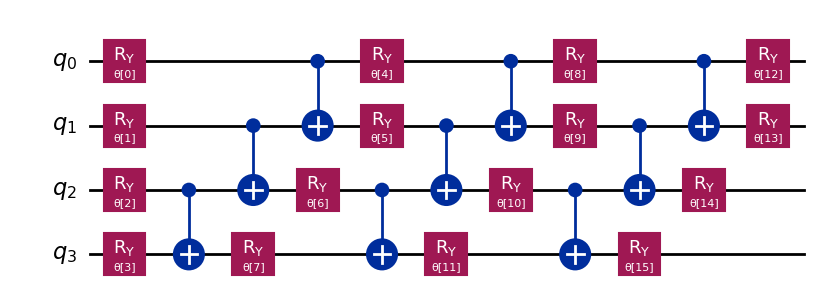

In [11]:
from qiskit.circuit.library import RealAmplitudes


ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)
ansatz.decompose().draw('mpl')

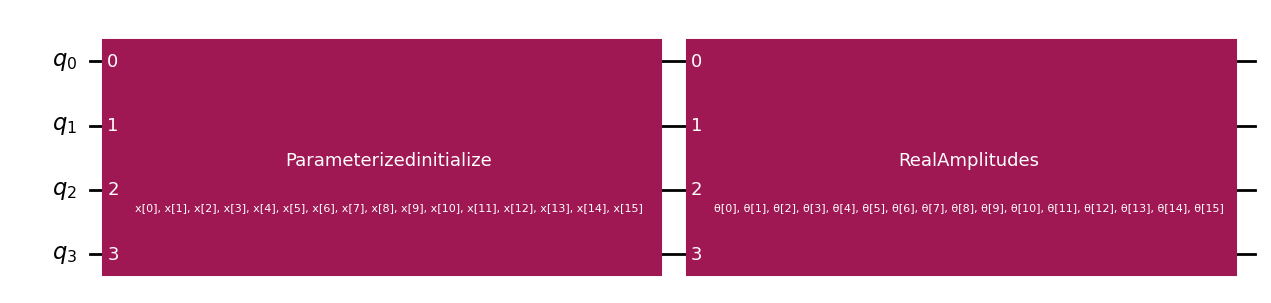

In [18]:
vqc_ckt = fm.compose(ansatz)
vqc_ckt.draw('mpl')

In [12]:
from qiskit.primitives import Estimator, Sampler
#estimator = Estimator()
sampler=Sampler()
x0 = np.random.rand(ansatz.num_parameters)
x0

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258,
       0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497,
       0.18340451])

In [13]:
def run_vqc_for_feature(vqc_ckt, sampler, params, feature):
    """
    Run a variational quantum circuit (VQC) for a given feature.

    Args:
        vqc_ckt (QuantumCircuit): The variational quantum circuit.
        sampler (Sampler): The sampler object for executing the circuit.
        params (list): The parameters of the circuit.
        feature (list): The feature values.

    Returns:
        list: Quasi-probability distribution obtained from the circuit.
    """
    qc = vqc_ckt.copy()  # Create a copy of the variational quantum circuit
    parameters = list(feature) + list(params)  # Concatenate the feature with the circuit parameters
    qc.measure_all()  # Measure all qubits in the circuit
    job = sampler.run(qc, parameters)  # Run the circuit with the specified parameters
    res = job.result().quasi_dists  # Get the quasi-probability distributions from the result
    return list(res[0].values())  # Extract the quasi-probability distribution for the first outcome

# Example usage:
# for i, feature in enumerate(training_features):
#     dis = run_vqc_for_feature(vqc_ckt, sampler, params, feature)
    # Process the quasi-probability distribution obtained from the VQC for the current feature
    # (e.g., use it to update model parameters, compute loss, etc.)


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCL(nn.Module):
    def __init__(self, input_size, output_size):
        super(FCL, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc(x)
        return x

# # Example usage:
# input_size = 2**n  # Size of the input vector
# output_size = d    # Size of the output vector

# # Initialize the model
# model = FCL(input_size, output_size)

# # Assuming your input_vector is a tensor of shape (batch_size, 2**n)
# # output_vector will be a tensor of shape (batch_size, d)
# output_vector = model(input_vector)


In [15]:
# Fully connected network
input_size = 2 ** num_qubits  # Size of the input vector (output states of QC)
output_size = 2  # Size of the output vector (number of classes)
model = FCL(input_size, output_size)
f_val = []
itr = 0
def train_quantum_nn(x0,X_train, y_train, sampler, feature_map, ansatz, num_qubits):
    global f_val
    global itr 
    fm,num_qubits = create_feature_map(size, encoding)
    ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3)

    vqc_ckt = fm.compose(ansatz)

    loss = []
    for i, feature in enumerate(X_train):
        # Run the variational quantum circuit for the current feature
        dis = run_vqc_for_feature(vqc_ckt, sampler, x0, feature)
        dis_tensor = torch.tensor(dis, dtype=torch.float32)
        # apply sigmoid on dis_tensor

        y_true = np.zeros(2**num_qubits)
        if y_train[i][0]>y_train[i][1]:
            for j in range(len(y_true)):
                if j%2==0:
                    y_true[j] = 1
        else:
            for j in range(len(y_true)):
                if j%2!=0:
                    y_true[j] = 1
            # y_true[1] = 1
        # Predict using the fully connected network
        # y_predicted = model(dis_tensor)
        # y_predicted_numpy = y_predicted.detach().numpy()
        # Compute and append the cross-entropy loss
        loss.append(cross_entropy(dis_tensor.detach().numpy(),y_true))

    # Compute the average loss
    cost = sum(loss) / len(loss)
    f_val.append(cost)

    # Display progress every 2 iterations
    
    print('Iteration:', itr, 'fun:', cost)

    itr += 1

    return cost


In [16]:
# model = FCL(2**num_qubits, 2)  # You need to define input_size and output_size here
# Train the model...
# After training, call the print_model_parameters function
print_model_parameters(model)

Weights:
tensor([[-0.2033,  0.0492, -0.0976,  0.2263, -0.2419,  0.0377, -0.0081,  0.0336,
          0.0491, -0.0166, -0.0549,  0.1579, -0.1845,  0.0100,  0.0915, -0.2196],
        [-0.2082,  0.1053,  0.1073, -0.0034,  0.2321, -0.2116, -0.2284,  0.0181,
          0.2202, -0.0292,  0.0558,  0.1478,  0.1011,  0.0069,  0.1952, -0.1487]])
Biases:
tensor([0.0848, 0.0186])


In [17]:
from scipy.optimize import minimize
opt_result = minimize(train_quantum_nn, x0, args=(X_train, y_train, sampler, fm, ansatz, num_qubits), method="COBYLA", options={'disp': True, 'ftol': 0.05, 'maxiter': 50})


/home/musa/anaconda3/envs/QIP/lib/python3.12/site-packages/scipy/optimize/_minimize.py:719: OptimizeWarning: Unknown solver options: ftol
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Iteration: 0 fun: 4.321034308022019
Iteration: 1 fun: 4.565932173941666
Iteration: 2 fun: 3.9036433439032625
Iteration: 3 fun: 4.610656618817823
Iteration: 4 fun: 3.938119873358617
Iteration: 5 fun: 3.9275257885432553
Iteration: 6 fun: 3.9006144019863704
Iteration: 7 fun: 4.050100141318946
Iteration: 8 fun: 3.185827744642454
Iteration: 9 fun: 3.5039666848082907
Iteration: 10 fun: 3.6906240940470494
Iteration: 11 fun: 3.3855876557590743
Iteration: 12 fun: 3.7673639189806374
Iteration: 13 fun: 4.118350929410101
Iteration: 14 fun: 3.6444965487735055
Iteration: 15 fun: 3.8854679576408424
Iteration: 16 fun: 3.919150236007775
Iteration: 17 fun: 3.2135580097315954
Iteration: 18 fun: 3.548958303746714
Iteration: 19 fun: 3.269861836194333
Iteration: 20 fun: 3.5448879037503898
Iteration: 21 fun: 3.2438328296828542
Iteration: 22 fun: 3.305418182708885
Iteration: 23 fun: 3.202414326869213
Iteration: 24 fun: 3.003565227811251
Iteration: 25 fun: 3.10565969766104
Iteration: 26 fun: 3.008695042354525


In [ ]:
para=list(opt_result.x)
para

[0.21067552900141845,
 2.0580671822987626,
 0.5795353681613165,
 0.6304543822162658,
 1.0378299180414459,
 0.12945470008262266,
 0.4912698084366427,
 2.0002807984179425,
 0.3747252755048531,
 0.8779663221168075,
 -0.006074035672666115,
 1.1586249038880834,
 0.7574296349318894,
 0.11098778577375958,
 0.15671931159413127,
 0.3103001184740306]

In [ ]:
print_model_parameters(model)

Weights:
tensor([[-0.0783,  0.0747, -0.0602,  0.1889,  0.1956, -0.0920, -0.0939, -0.1825,
          0.1106, -0.0484,  0.2435, -0.2311, -0.0699,  0.0920, -0.0294,  0.1683],
        [-0.1553,  0.1146,  0.1619,  0.0335, -0.0161, -0.1628,  0.1531, -0.1450,
          0.0298, -0.2082, -0.1587,  0.2295, -0.1947, -0.2248,  0.1911,  0.2296]])
Biases:
tensor([-0.0042,  0.1959])


In [ ]:

def evaluate_model(X_test, y_test, sampler, feature_map, ansatz, num_qubits, trained_params):
    """
    Evaluate the quantum neural network on the test set.

    Args:
        X_test (numpy.ndarray): Test features.
        y_test (numpy.ndarray): True labels for the test set.
        sampler (Sampler): The sampler object for executing the circuit.
        feature_map (QuantumCircuit): Feature map circuit.
        ansatz (QuantumCircuit): Ansatz circuit.
        num_qubits (int): Number of qubits.
        trained_params (numpy.ndarray): Trained parameters for the quantum neural network.

    Returns:
        float: Accuracy of the model on the test set.
    """
    correct = 0
    total = len(X_test)

    vqc_ckt = feature_map.compose(ansatz)
    predictions=[]
    for i, feature in enumerate(X_test):
        # Run the variational quantum circuit for the current feature
        dis = run_vqc_for_feature(vqc_ckt, sampler, trained_params, feature)
        dis_tensor = torch.tensor(dis, dtype=torch.float32)
        # print(dis_tensor)
        # print(dis_tensor)
        # Predict using the fully connected network
        y_predicted = model(dis_tensor)
        # print(y_predicted.data)
        cl0=0
        cl1=0
        for j in range(len(dis_tensor)):
            if j%2==0:
                cl0+=dis_tensor[j]
            else:
                cl1+=dis_tensor[j]
        print(f'class0={cl0},class1={cl1}')
        predicted= 1 if cl1>cl0 else 0
        # predicted = torch.argmax(dis_tensor)
        predictions.append(predicted)
        # print(cl)
        # print(torch.argmax(torch.tensor(y_test[i])))
        # _, predicted = torch.max(y_predicted.data)
        
        # Check prediction accuracy
        if predicted == torch.argmax(torch.tensor(y_test[i])):
            correct += 1
    print(predictions)
    accuracy = correct / total
    return accuracy

# Assuming opt_result.x contains the optimized parameters
accuracy = evaluate_model(X_test, y_test, sampler, fm, ansatz, num_qubits, opt_result.x)
print("Accuracy on test set:", accuracy)


class0=0.6270113587379456,class1=0.3729887306690216
class0=0.5093247294425964,class1=0.49067530035972595
class0=0.5495800971984863,class1=0.4504198729991913
class0=0.6116782426834106,class1=0.3883216977119446
class0=0.5510209202766418,class1=0.44897907972335815
class0=0.5563110709190369,class1=0.44368892908096313
class0=0.5837984085083008,class1=0.416201651096344
class0=0.5825875997543335,class1=0.4174123704433441
class0=0.5330216288566589,class1=0.46697837114334106
class0=0.6083783507347107,class1=0.3916216790676117
class0=0.534231960773468,class1=0.46576809883117676
class0=0.5102816820144653,class1=0.48971837759017944
class0=0.5514107942581177,class1=0.4485892057418823
class0=0.558386504650116,class1=0.44161343574523926
class0=0.5857822895050049,class1=0.41421768069267273
class0=0.4739905595779419,class1=0.5260094404220581
class0=0.5830840468406677,class1=0.4169159531593323
class0=0.5330238342285156,class1=0.4669761061668396
class0=0.6062449216842651,class1=0.3937550485134125
class0=

In [57]:
# Assuming 'model' is your fully connected model
def print_model_parameters(model):
    """
    Print the parameters (weights and biases) of the fully connected model.

    Args:
        model (FCL): The fully connected model.
    """
    # Access the linear layer of the model
    linear_layer = model.fc
    
    # Print weights and biases
    print("Weights:")
    print(linear_layer.weight.data)
    print("Biases:")
    print(linear_layer.bias.data)

# Assuming 'model' is your fully connected model
# You need to instantiate the model before printing its parameters
model = FCL(2**num_qubits, 2)  # You need to define input_size and output_size here
# Train the model...
# After training, call the print_model_parameters function
print_model_parameters(model)


Weights:
tensor([[-0.0921, -0.1845, -0.1678,  0.1679,  0.2340, -0.1391,  0.0226,  0.1885,
         -0.1140,  0.2356,  0.1285, -0.2319, -0.0580, -0.0733,  0.1004,  0.2294],
        [ 0.2488, -0.1282, -0.1971,  0.2063, -0.0611, -0.1598, -0.0852,  0.2178,
          0.1662,  0.2327,  0.0293, -0.0914, -0.0642,  0.2474, -0.1501, -0.2122]])
Biases:
tensor([0.1272, 0.2109])


In [10]:
f_val=[]
itr=0
def cost_func(params, training_features, training_labels, sampler,feature_map,ansatz):
    """Return estimate of energy from sampler

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit

    Returns:
        float: Energy estimate
    """
    global f_val,itr
    # feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear") ## Choose feagture map
    feature_map = fm

    # ansatz = TwoLocal(feature_map.num_qubits, ["ry", "rz"], "cz", reps=3)
    ansatz = ansatz

    vqc_ckt = feature_map.compose(ansatz)

    loss=[]
    for i,x in enumerate(training_features):
        qc=vqc_ckt.copy()
        parameters=list(x)+list(params)
        qc.measure_all()
        job=sampler.run(qc,parameters)
        res=job.result().quasi_dists
        dis = list(res[0].values())
        # print(res)
        # Format  output
        # y_true=list(np. zeros(2))
        # if training_labels[i][0]==1:
        #     y_true[0]=1
        # else:
        #     y_true[1]=1
        
        # classes = [0, 0]
        # dis = list(res[0].values())
        # for j in range(len(dis)):
        #     if j%2==0:
        #         classes[0]+=dis[j]
        #     else:
        #         classes[1]+=dis[j]
        # y_pred=list(np. zeros(2))
        # if classes[0]>classes[1]:
        #     y_pred[0]=1
        # else:
        #     y_pred[1]=1

        # print(y_pred, y_true)
        # loss.append(cross_entropy(y_pred, y_true))
        y_true=list(np. zeros(2**qc.num_qubits))
        if training_labels[i][0]==1:
            for j in range(2**qc.num_qubits):
                if j%2==0:
                    y_true[j]=1
            # y_true[1]=1
        else:
            for j in range(2**qc.num_qubits):
                if j%2!=0:
                    y_true[j]=1
            # y_true[2]=1
        y_pred=list(res[0].values())

        #print(y_pred, y_true)
        loss.append(cross_entropy(y_pred, y_true))
        
    cost=sum(loss)/len(loss)
    f_val.append(cost)

    if itr%2==0:
        print('Iteration:',itr,'fun:',cost)
    itr=itr+1

    return cost

In [11]:
from qiskit.primitives import Estimator, Sampler
#estimator = Estimator()
sampler=Sampler()
#x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)  ## Initial value      #43

# x0=np.array ([0.45923317, 0.49371866, 0.57551473, 0.84051917, 0.25993984, 0.66425266,
#  0.16559752, 0.63738022, 0.93002718, 0.0168024  ,0.64698912 ,0.56321298,
#  0.3359864 , 0.62684042, 0.54548639, 0.03302976,0.45923317, 0.49371866, 0.57551473, 0.84051917, 0.25993984, 0.66425266,
#  0.16559752, 0.63738022, 0.93002718, 0.0168024  ,0.64698912 ,0.56321298,
#  0.3359864 , 0.62684042, 0.54548639, 0.03302976,])

# x0=np.array([ 0.54984404, -0.41036317,  0.20175046,  2.65439476,  0.39962775,
#         0.57569455,  2.40122922,  2.18254696,  3.31398097,  1.26346976,
#         0.42897529,  2.24253612, -0.59721792,  1.76331745,  1.14339952,
#         0.22966247])

x0 = np.random.rand(ansatz.num_parameters)
x0

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258,
       0.02058449, 0.96990985])

In [12]:
%%time
# SciPy minimizer routine
from scipy.optimize import minimize
opt = minimize(cost_func, x0, args=(X_train, y_train, sampler,fm,ansatz), method="COBYLA", options={'disp': True, 'ftol':0.05, 'maxiter':20})



/home/musa/anaconda3/envs/QIP/lib/python3.12/site-packages/scipy/optimize/_minimize.py:719: OptimizeWarning: Unknown solver options: ftol
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


Iteration: 0 fun: 36.70197684726351
Iteration: 2 fun: 35.009148951145214
Iteration: 4 fun: 35.8974796810042
Iteration: 6 fun: 30.537365932611877
Iteration: 8 fun: 27.000105184123917
Iteration: 10 fun: 34.67080118683496
Iteration: 12 fun: 27.696188491073706
Iteration: 14 fun: 24.52974327730067
Iteration: 16 fun: 26.53414431078724
Iteration: 18 fun: 25.282084095572923
CPU times: user 13min 33s, sys: 40.3 s, total: 14min 13s
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   20   F = 2.452974E+01    MAXCV = 0.000000E+00
   X = 1.893201E+00   2.068978E+00   5.216574E-01   5.264796E-01   1.170797E+00
       1.504559E+00  -3.032842E-01   2.153586E+00   1.660046E+00   2.588022E-02
      -2.963536E-01   8.544202E-01

Wall time: 13min 53s


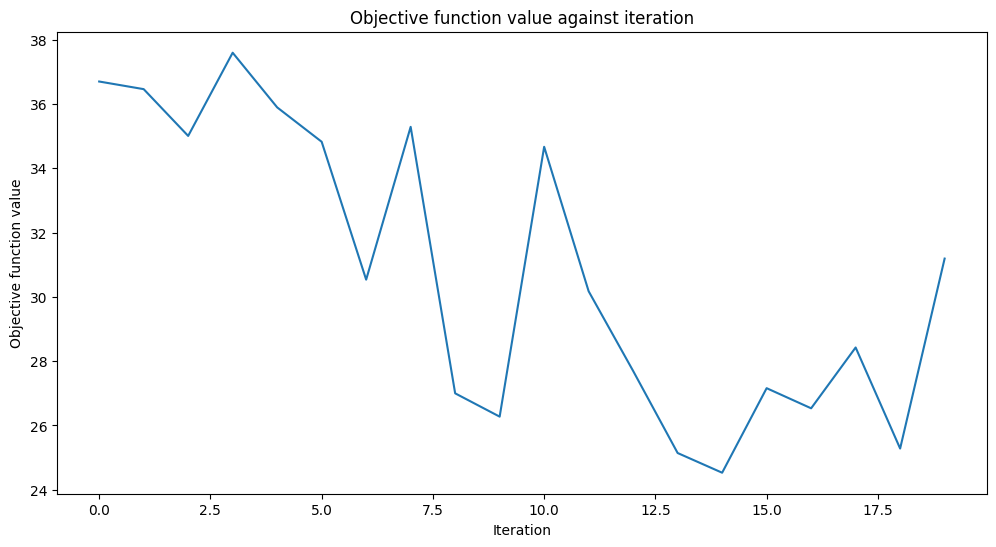

In [13]:

plt.rcParams["figure.figsize"] = (12, 6)
plt.title("Objective function value against iteration")
plt.xlabel("Iteration")
plt.ylabel("Objective function value")
plt.plot(range(len(f_val)), f_val)
plt.show()


In [14]:
para=list(opt.x)
lst=[]
# feature_map = ZZFeatureMap(feature_dimension=size, reps=2, entanglement="linear") ## Choose feagture map
# ansatz = TwoLocal(fm.num_qubits, ["ry", "rz"], "cz", reps=3)
vqc_ckt = fm.compose(ansatz)

for i in range(len(X_train)):
    qc=vqc_ckt.copy()
    parameters=list(X_train[i])+para
    qc.measure_all()
    job=sampler.run(qc,parameters)
    res=job.result().quasi_dists
    lst.append(res)

lb=[]
for i in lst:
    k=list(i[0].keys())
    v=list(i[0].values())
    lb.append(k[v.index(max(v))])
print(lb)
print(y_train)

[11, 11, 11, 10, 11, 10, 10, 10, 10, 11, 11, 10, 10, 10, 10, 10, 11, 13, 11, 10, 10, 11, 11, 11, 10, 10, 10, 11, 11, 10, 10, 10, 13, 11, 10, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 10, 11, 10, 10, 10, 11, 10, 10, 11, 10, 11, 11, 10, 11, 10, 10, 10, 11, 11, 11, 11, 14, 11, 14, 14, 10, 14, 10, 11, 11, 10, 11, 14, 10, 11, 10, 11, 11, 11, 10, 11, 11, 11, 11, 11, 10, 11, 11, 11, 10, 10, 11, 11, 10, 10, 10, 11, 11, 11, 11, 11, 10, 11, 10, 11, 4, 10, 14, 10, 11, 11, 10, 10, 14, 10, 10, 11, 14, 11, 10, 11, 10, 11, 10, 11, 10, 11, 11, 10, 10, 11, 10, 10, 14, 11, 11, 10, 10, 11, 10, 11, 11, 10, 11, 11, 11, 10, 10, 11, 11, 10, 11, 11, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 11, 10, 10, 10, 11, 10, 10, 10, 11, 10, 10, 4, 10, 10, 10, 10, 10, 11, 11, 10, 11, 10, 11, 11, 10, 10, 10, 11, 10, 11, 10, 10, 10, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 10, 10, 11, 10, 10, 11, 11, 10, 11, 11, 11, 11, 11, 10, 10, 11, 14, 10, 11, 14, 10, 11, 11, 6, 11, 10, 11, 11, 10, 11

In [18]:
para=list(opt.x)
lst=[]
# feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement="linear") ## Choose feagture map
# ansatz = TwoLocal(feature_map.num_qubits, ["ry", "rz"], "cz", reps=3)
vqc_ckt = fm.compose(ansatz)

for i in range(len(X_test)):
    qc=vqc_ckt.copy()
    parameters=list(X_test[i])+para
    qc.measure_all()
    job=sampler.run(qc,parameters)
    res=job.result().quasi_dists
    lst.append(res)



In [30]:
list(np. zeros(2**qc.num_qubits))

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [33]:
# def give_class(v):
lb=[]

for i in lst:
    k=list(i[0].keys())
    v=list(i[0].values())
    print(len(v))
    class1=0
    class2=0
    for j in range(len(v)):
        if j%2==0:
            class1+=v[j]
        else:
            class2+=v[j]
    lb.append(1 if class1>class2 else 0)
        

print(lb)
# print(y_test)


16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
1

In [ ]:
## Approach 

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
#import nn
import torch.nn as nn

# Define the size of the images
size = 4  # MNIST images are 28x28

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((size, size))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Define the network
class Net(nn.Module):
    def __init__(self, size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(size * size, 10 * size * size)
        self.fc2 = nn.Linear(10 * size * size, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

# Instantiate the model
model = Net(size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the network
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs.view(-1, size * size))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

# Testing the network
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images.view(-1, size * size))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


[1,   100] loss: 2.176
[1,   200] loss: 1.839
[1,   300] loss: 1.460
[1,   400] loss: 1.210
[1,   500] loss: 1.073
[1,   600] loss: 0.986
[1,   700] loss: 0.909
[1,   800] loss: 0.842
[1,   900] loss: 0.825
[2,   100] loss: 0.820
[2,   200] loss: 0.779
[2,   300] loss: 0.761
[2,   400] loss: 0.754
[2,   500] loss: 0.758
[2,   600] loss: 0.746
[2,   700] loss: 0.727
[2,   800] loss: 0.694
[2,   900] loss: 0.703
[3,   100] loss: 0.672
[3,   200] loss: 0.723
[3,   300] loss: 0.716
[3,   400] loss: 0.720
[3,   500] loss: 0.680
[3,   600] loss: 0.670
[3,   700] loss: 0.680
[3,   800] loss: 0.664
[3,   900] loss: 0.682
[4,   100] loss: 0.680
[4,   200] loss: 0.695
[4,   300] loss: 0.677
[4,   400] loss: 0.660
[4,   500] loss: 0.651
[4,   600] loss: 0.643
[4,   700] loss: 0.677
[4,   800] loss: 0.675
[4,   900] loss: 0.648
[5,   100] loss: 0.652
[5,   200] loss: 0.662
[5,   300] loss: 0.651
[5,   400] loss: 0.682
[5,   500] loss: 0.629
[5,   600] loss: 0.651
[5,   700] loss: 0.676
[5,   800] 